In [63]:
%pip install -qU langchain langchain_openai langgraph 

Note: you may need to restart the kernel to use updated packages.


In [64]:
from langchain_openai import AzureChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.schema.output_parser import StrOutputParser
from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.tools import tool
from langgraph.graph import END, StateGraph

from typing import Annotated, List, TypedDict
import os
from pathlib import Path
from operator import itemgetter, add
import functools

In [72]:
WORKING_DIRECTORY = Path(f"{os.getcwd()}\\generated")

In [3]:
api_key = "a1ab70e0f13c4db1b2236ae9ea986511"
api_version = "2024-05-01-preview"

In [55]:
llm = AzureChatOpenAI(
  model="gpt-4o",
  api_key=api_key,
  api_version=api_version,
  azure_endpoint = f"https://james-ai.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version={api_version}"
)

llm

AzureChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x00000198A2246090>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x00000198A2247470>, model_name='gpt-4o', openai_api_key=SecretStr('**********'), openai_proxy='', azure_endpoint='https://james-ai.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-05-01-preview', openai_api_version='2024-05-01-preview', openai_api_type='azure')

In [84]:
RAG_PROMPT = """
CONTEXT:
{context}

QUESTION:
{question}

You are a helpful assistant knowledgeable in Prisma.
Use the available prisma schema context as the examples to generate a prisma schema based on the model names given in the question.
Make sure that the datasource db and generator client are added on the generated schema.
Make sure that the fields createdAt, updatedAt, and deletedAt are added to the models.
Make sure that the schema is valid and correct based on the given question.
If you can't answer the question, say you don't know.
If the question is unclear or not related to Prisma, say you don't know.
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

In [57]:
directory_path = Path('templates/')

contents = {'data': ''}

for file_path in directory_path.glob('*.prisma'):
    content = file_path.read_text()
    contents['data'] += (f"Example for {file_path.stem.upper()}:\n{content}\n")

contents

{'data': 'Example for MANY-TO-MANY:\n// Define the User model  \nmodel User {\n  id        String         @id @default(cuid()) // Unique identifier for each user  \n  email     String         @unique // Unique email for each user  \n  name      String? // Optional name field  \n  projects  UserProjects[] // Relation to the UserProjects model for many-to-many relationship  \n  createdAt DateTime       @default(now()) // Timestamp of user creation  \n  updatedAt DateTime       @updatedAt // Timestamp of the last update  \n}\n\n// Define the Project model  \nmodel Project {\n  id        String         @id @default(cuid()) // Unique identifier for each project  \n  name      String // Name of the project  \n  users     UserProjects[] // Relation to the UserProjects model for many-to-many relationship  \n  createdAt DateTime       @default(now()) // Timestamp of project creation  \n  updatedAt DateTime       @updatedAt // Timestamp of the last update  \n}\n\n// Define the UserProjects model

In [85]:
chain = (
    {"context": itemgetter("context"), "question": itemgetter("question")}
    | rag_prompt | llm | StrOutputParser()
)

In [41]:
chain.invoke({"context": contents['data'], "question" : "What does the 'context' in 'long context' refer to?"})

"I'm sorry, but I don't have the information necessary to answer your question about the meaning of 'context' in 'long context.' If you have any other questions or need assistance with Prisma schema, feel free to ask!"

In [42]:
chain.invoke({"context": contents['data'], "question" : "Create a prisma schema with the models case, party, document, action, timespent, and reimbursement, cases can contain many of the mentioned models thus the case model has a one-to-many relationship with them ?"})

"Sure, I can help you create a Prisma schema based on the given models and relationships. Here's a schema where the `Case` model has a one-to-many relationship with the `Party`, `Document`, `Action`, `TimeSpent`, and `Reimbursement` models:\n\n```prisma\n// Define the Case model\nmodel Case {\n  id            String         @id @default(cuid()) // Unique identifier for each case\n  caseNumber    String         @unique // Unique case number\n  title         String // Title of the case\n  parties       Party[] // One-to-many relation to the Party model\n  documents     Document[] // One-to-many relation to the Document model\n  actions       Action[] // One-to-many relation to the Action model\n  timespents    TimeSpent[] // One-to-many relation to the TimeSpent model\n  reimbursements Reimbursement[] // One-to-many relation to the Reimbursement model\n  createdAt     DateTime       @default(now()) // Timestamp of case creation\n  updatedAt     DateTime       @updatedAt // Timestamp of t

In [53]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

In [47]:
def create_agent(
    llm: AzureChatOpenAI,
    tools: list,
    system_prompt: str,
) -> str:
    """Create a function-calling agent and add it to the graph."""
    system_prompt += "\nWork autonomously according to your specialty, using the tools available to you."
    " Do not ask for clarification."
    " Your other team members will collaborate with you with their own specialties."
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_functions_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

In [48]:
def create_team_supervisor(llm: AzureChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                "Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )

In [86]:
@tool
def generate_schema(
    query: Annotated[str, "query to ask the generate schema tool"]
    ):
  """Use Retrieval Augmented Generation to generate a Prisma Schema"""
  return chain.invoke({"context": contents['data'], "question" : query})

In [73]:
@tool
def write_schema(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"

In [87]:
class SchemaGenerationState(TypedDict):
    messages: Annotated[List[BaseMessage], add]
    team_members: str
    next: str
    current_files: str

In [88]:
def prelude(state):
    written_files = []
    if not WORKING_DIRECTORY.exists():
        WORKING_DIRECTORY.mkdir()
    try:
        written_files = [
            f.relative_to(WORKING_DIRECTORY) for f in WORKING_DIRECTORY.rglob("*")
        ]
    except:
        pass
    if not written_files:
        return {**state, "current_files": "No files written."}
    return {
        **state,
        "current_files": "\nBelow are files your team has written to the directory:\n"
        + "\n".join([f" - {f}" for f in written_files]),
    }

In [89]:
generate_schema_agent = create_agent(
    llm,
    [generate_schema],
    "You are an expert in generating Prisma Schemas.\n",
)
schema_generating_node = functools.partial(agent_node, agent=generate_schema_agent, name="SchemaGenerator")

In [90]:
schema_writer_agent = create_agent(
    llm,
    [write_schema],
    "You are an expert in writing Prisma Schemas.\n"
    "Below are files currently in your directory:\n{current_files}",
)
context_aware_doc_writer_agent = prelude | schema_writer_agent
schema_writing_node = functools.partial(
    agent_node, agent=context_aware_doc_writer_agent, name="SchemaWriter"
)

In [91]:
schema_generation_supervisor = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {team_members}."
    "Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["SchemaWriter", "SchemaGenerator"],
)

In [92]:
schema_generation_graph = StateGraph(SchemaGenerationState)
schema_generation_graph.add_node("SchemaGenerator", schema_generating_node)
schema_generation_graph.add_node("SchemaWriter", schema_writing_node)
schema_generation_graph.add_node("supervisor", schema_generation_supervisor)

schema_generation_graph.add_edge("SchemaGenerator", "supervisor")
schema_generation_graph.add_edge("SchemaWriter", "supervisor")

schema_generation_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "SchemaGenerator": "SchemaGenerator",
        "SchemaWriter": "SchemaWriter",
        "FINISH": END,
    },
)

schema_generation_graph.set_entry_point("supervisor")
graph = schema_generation_graph.compile()

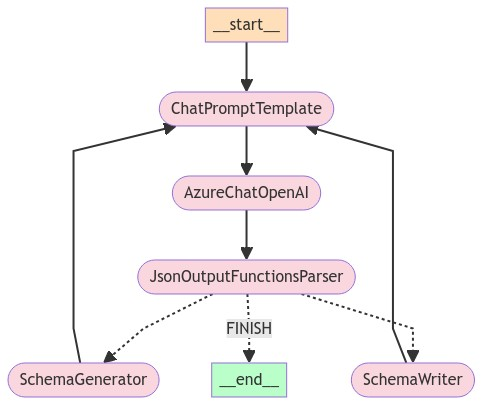

In [93]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

In [94]:
def enter_chain(message: str, members: List[str]):
    results = {
        "messages": [HumanMessage(content=message)],
        "team_members": ", ".join(members),
    }
    return results

schema_generation_chain = (
    functools.partial(enter_chain, members=schema_generation_graph.nodes)
    | schema_generation_graph.compile()
)

In [95]:
for s in schema_generation_chain.stream(
    "Create a prisma schema with the models case, party, document, action, timespent, and reimbursement, cases can contain many of the mentioned models thus the case model has a one-to-many relationship with them.",
    {"recursion_limit": 150},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'SchemaGenerator'}}
---
{'SchemaGenerator': {'messages': [HumanMessage(content='Here is the generated Prisma schema that includes the models `Case`, `Party`, `Document`, `Action`, `TimeSpent`, and `Reimbursement`. The `Case` model has a one-to-many relationship with all other models:\n\n```prisma\n// Define the datasource and generator\ndatasource db {\n  provider = "postgresql" // You can change this to your preferred database provider\n  url      = env("DATABASE_URL")\n}\n\ngenerator client {\n  provider = "prisma-client-js"\n}\n\n// Define the Case model\nmodel Case {\n  id            String          @id @default(cuid()) // Unique identifier for each case\n  name          String          // Name of the case\n  parties       Party[]         // One-to-many relation to the Party model\n  documents     Document[]      // One-to-many relation to the Document model\n  actions       Action[]        // One-to-many relation to the Action model\n  timespents    TimeSpe